# Задача прогнозирования биологического ответа

## Условия задачи

Необходимо предсказать биологический ответ молекул (столбец '**Activity**') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.


Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

## Подгружаем необходимые библиотеки

In [102]:
import pandas as pd # для анализа и предобработки данных
import numpy as np # для работы с матричными вычислениями

import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.model_selection import cross_val_score # для кросс-валидации

from sklearn.model_selection import GridSearchCV # для оптимизации гиперпараметров
from sklearn.model_selection import RandomizedSearchCV # для оптимизации гиперпараметров

import hyperopt # для оптимизации гиперпараметров
from hyperopt import hp, fmin, tpe, Trials #

import optuna # для оптимизации гиперпараметров


## Подгружаем данные

In [103]:
data = pd.read_csv('data/_train_sem09 (1).csv')
data.head(5)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


## Знакомство с данными

In [104]:
data.head(5)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


**Признаки:**

* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [106]:
data.describe()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.542255,0.076948,0.592436,0.068142,0.038990,0.212112,0.686653,0.274713,0.455133,0.749517,...,0.026926,0.014663,0.013863,0.021861,0.015196,0.016796,0.012263,0.011730,0.020261,0.011197
std,0.498278,0.079989,0.105860,0.078414,0.115885,0.102592,0.078702,0.090017,0.162731,0.071702,...,0.161889,0.120215,0.116938,0.146249,0.122348,0.128522,0.110074,0.107683,0.140911,0.105236
min,0.000000,0.000000,0.282128,0.000000,0.000000,0.002630,0.137873,0.006130,0.000000,0.275590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033300,0.517811,0.000000,0.000000,0.138118,0.625627,0.207374,0.378062,0.707339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.066700,0.585989,0.050000,0.000000,0.190926,0.674037,0.277845,0.499942,0.738961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.100000,0.668395,0.100000,0.000000,0.261726,0.740663,0.335816,0.569962,0.788177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.964381,0.950000,1.000000,1.000000,0.994735,0.790831,0.989870,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Проверим нулевые значения

In [107]:
data.isnull().sum()

Activity    0
D1          0
D2          0
D3          0
D4          0
           ..
D1772       0
D1773       0
D1774       0
D1775       0
D1776       0
Length: 1777, dtype: int64

смотрим сбалансированность классов

<AxesSubplot: xlabel='Activity', ylabel='count'>

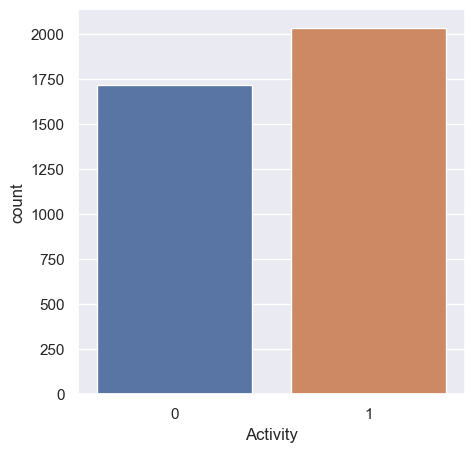

In [108]:
sns.countplot(data=data, x='Activity')

In [109]:
data['Activity'].value_counts(True)

1    0.542255
0    0.457745
Name: Activity, dtype: float64

данные сбалансированны

## Первичное обучение моделей

Создадим матрицу наблюдений $X$ и вектор ответов $y$

In [110]:
X = data.drop('Activity', axis=1)
y = data['Activity']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Обучим модель логистической регрессии

In [112]:
log_reg = linear_model.LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train,y_train)
lr_y_test_predicted = log_reg.predict(X_test)
lr_y_train_predicted = log_reg.predict(X_train)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, lr_y_test_predicted)))
print('f1_score на тренировчном наборе: {:.2f}'.format(metrics.f1_score(y_train, lr_y_train_predicted)))

f1_score на тестовом наборе: 0.78
f1_score на тренировчном наборе: 0.89


### Обучим модель случайный лес

In [113]:
rand_forest = ensemble.RandomForestClassifier(random_state=42)
rand_forest.fit(X_train,y_train)
rf_y_text_predicted = rand_forest.predict(X_test)
rf_y_train_predicted = rand_forest.predict(X_train)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, rf_y_text_predicted)))
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, rf_y_train_predicted)))

f1_score на тестовом наборе: 0.80
f1_score на тренировочном наборе: 1.00


### Промежуточные выводы

* Модель логистической регрессии показывает неплохии результаты
* Модель случайный лес демострирует признаки переобученности

## Оптимизация гиперпараметров моделей

### GridSearchCV

#### оптимизация гиперпараметров логистической регрессии по GridSearchCV

In [114]:
param_grid_log_reg = [{'penalty': ['l2','none'],
              'solver': ['lbfgs','saga'],
              'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
              ]

In [115]:
grid_search_log = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid_log_reg,
    cv=5,
    n_jobs=-1
)

grid_search_log.fit(X_train, y_train)
y_test_predicted_log = grid_search_log.predict(X_test)


In [116]:
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search_log.score(X_test, y_test)))
print('accuracy на обучающий наборе: {:.2f}'.format(grid_search_log.score(X_train, y_train)))
print('f1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log)))
print('наилучшее значение гиперпараметров: {}'.format(grid_search_log.best_params_))
print('лучшая модель: {}'.format(grid_search_log.best_estimator_))


accuracy на тестовом наборе: 0.75
accuracy на обучающий наборе: 0.82
f1 на тестовой выборке: 0.78
наилучшее значение гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}
лучшая модель: LogisticRegression(C=0.3, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')


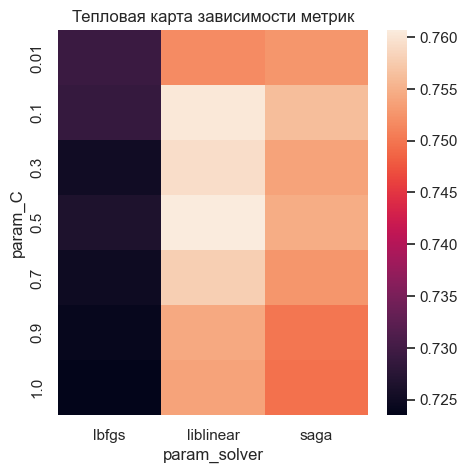

In [117]:

visual_grid_search_log = pd.pivot_table(pd.DataFrame(grid_search_log.cv_results_), values='mean_test_score', index='param_C', columns='param_solver')
sns.heatmap(visual_grid_search_log)
plt.title('Тепловая карта зависимости метрик')
sns.set(rc={'figure.figsize':(5,10)})

#### оптимизация гиперпараметров случайный лес по GridSearchCV

In [118]:
param_grid_rf = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))}

In [119]:
grid_search_rf = GridSearchCV(ensemble.RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              cv=5,
                              n_jobs=-1
                              )

grid_search_rf.fit(X_train,y_train)
y_test_predicted_grid_search_rf = grid_search_rf.predict(X_test)

In [120]:
print('accuracy на обучающей выбоке: {:.2f}'.format(grid_search_rf.score(X_train,y_train)))
print('accuracy на тестовой выборке: {:.2f}'.format(grid_search_rf.score(X_test, y_test)))
print('f1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test,y_test_predicted_grid_search_rf)))
print('наилучшие значения гиперпараметров: {}'.format(grid_search_rf.best_params_))
print('наилучшая модель: {}'.format(grid_search_rf.best_estimator_))

accuracy на обучающей выбоке: 0.94
accuracy на тестовой выборке: 0.78
f1 на тестовой выборке: 0.80
наилучшие значения гиперпараметров: {'max_depth': 22, 'min_samples_leaf': 5, 'n_estimators': 170}
наилучшая модель: RandomForestClassifier(max_depth=22, min_samples_leaf=5, n_estimators=170,
                       random_state=42)


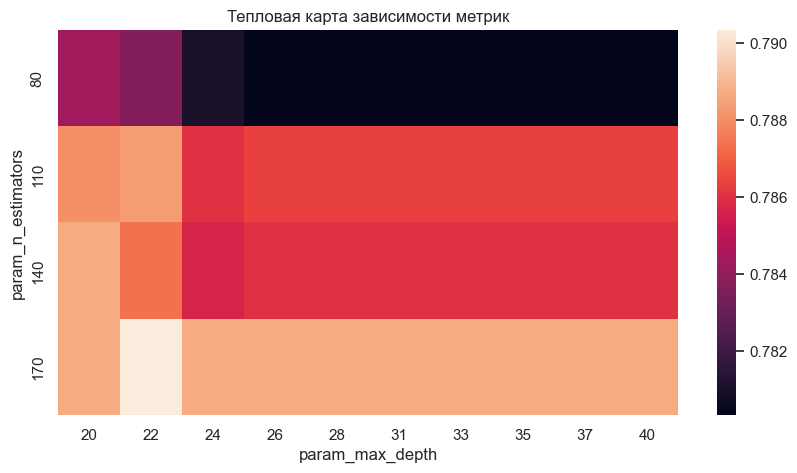

In [128]:
visual_grid_search_rf = pd.pivot_table(pd.DataFrame(grid_search_rf.cv_results_), values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
sns.heatmap(visual_grid_search_rf)
plt.title('Тепловая карта зависимости метрик')
sns.set(rc={'figure.figsize':(5,5)})

### RANDOMIZEDSEARCHCV 

#### оптимизация гиперпараметров логистической регрессии RANDOMIZEDSEARCHCV

In [122]:
randomized_search_log = RandomizedSearchCV(estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000),
                                           param_distributions=param_grid_log_reg,
                                           cv=5,
                                           n_iter=50,
                                           n_jobs=-1)

randomized_search_log.fit(X_train,y_train)
lr_rs_y_train_predicted = randomized_search_log.predict(X_train)
lr_rs_y_test_predicted = randomized_search_log.predict(X_test)

c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [123]:
print('accuracy на обучающей выбоке: {:.2f}'.format(randomized_search_log.score(X_train,y_train)))
print('accuracy на тестовой выборке: {:.2f}'.format(randomized_search_log.score(X_test, y_test)))
print('f1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test,lr_rs_y_test_predicted)))
print('f1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train,lr_rs_y_train_predicted)))
print('наилучшие значения гиперпараметров: {}'.format(randomized_search_log.best_params_))
print('наилучшая модель: {}'.format(randomized_search_log.best_estimator_))

accuracy на обучающей выбоке: 0.82
accuracy на тестовой выборке: 0.75
f1 на тестовой выборке: 0.78
f1 на обучающей выборке: 0.84
наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.3}
наилучшая модель: LogisticRegression(C=0.3, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')


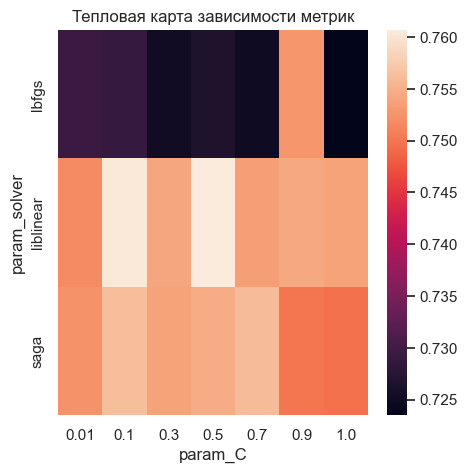

In [125]:
visual_randomized_search_log = pd.pivot_table(pd.DataFrame(randomized_search_log.cv_results_),values='mean_test_score', index='param_solver', columns='param_C')
sns.heatmap(visual_randomized_search_log)
plt.title('Тепловая карта зависимости метрик')
sns.set(rc={'figure.figsize':(5,10)})

#### оптимизация гиперпараметров случайного леса RANDOMIZEDSEARCHCV

In [129]:
randomized_search_rf = RandomizedSearchCV(estimator=ensemble.RandomForestClassifier(random_state=42),
                                          param_distributions=param_grid_rf,
                                          cv=5,
                                          n_iter=50,
                                          n_jobs=-1)

randomized_search_rf.fit(X_train,y_train)
y_test_predicted_rand_rf = randomized_search_rf.predict(X_test)
y_train_predicted_rand_rf = randomized_search_rf.predict(X_train)

c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [130]:
print('accuracy на обучающей выборке: {:.2f}'.format(randomized_search_rf.score(X_train,y_train)))
print('accuracy на тестовой выборке: {:.2f}'.format(randomized_search_rf.score(X_test,y_test)))
print('f1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_predicted_rand_rf)))
print('f1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_rand_rf)))
print('наилучшии значения геперпараметров: {}'.format(randomized_search_rf.best_params_))
print('наилучшая модель: {}'.format(randomized_search_rf.best_estimator_))

accuracy на обучающей выборке: 0.94
accuracy на тестовой выборке: 0.78
f1 на обучающей выборке: 0.95
f1 на тестовой выборке: 0.80
наилучшии значения геперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 22}
наилучшая модель: RandomForestClassifier(max_depth=22, min_samples_leaf=5, n_estimators=170,
                       random_state=42)


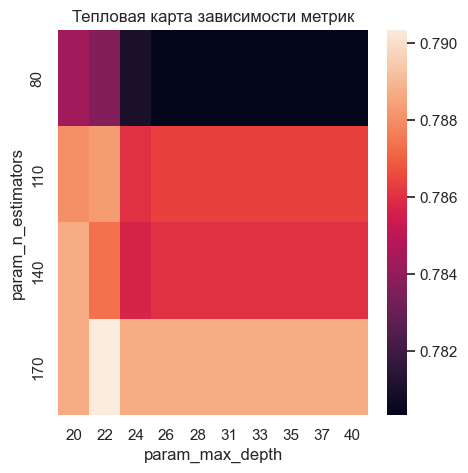

In [133]:
visual_randomized_search_rf = pd.pivot_table(pd.DataFrame(randomized_search_rf.cv_results_), values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
sns.heatmap(visual_randomized_search_rf)
plt.title('Тепловая карта зависимости метрик')
sns.set(rc={'figure.figsize':(5,5)})

### HYPEROPT

####  оптимизация гиперпараметров логистической регрессии HYPEROPT

##### 1

In [166]:
space_log_reg={'penalty' : hp.choice(label='penalty', options=['l2','none']),
       'solver' : hp.choice(label='solver', options=['lbfgs','saga']),
       'C' : hp.uniform(label='C', low=0.01, high=1)
       }
       

In [161]:
random_state = 42

def hyperopt_log_reg(params, cv=5, X=X_train, y=y_train, random_state = random_state):
    params = {
                'penalty': str(params['penalty']),
                'solver': str(params['solver']),
                'C': float(params['C'])
            }
    
    model = linear_model.LogisticRegression(**params, random_state=random_state)
    
    model.fit(X,y)
    #score = metrics.f1_score(y, model.predict(X))
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return - score
    
    

In [ ]:
trials = hyperopt.Trials()

best = fmin(hyperopt_log_reg,
            space=space_log_reg,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials,
            rstate=np.random.default_rng(random_state)
            )

In [168]:
print('Наилучшее значение гиперпараметров {}'.format(best))

Наилучшее значение гиперпараметров {'C': 0.05084775379720359, 'penalty': 0, 'solver': 0}


In [184]:
log_reg_hyp = linear_model.LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    C=0.5,
    max_iter=1000
    )

log_reg_hyp.fit(X_train,y_train)
y_test_predicted_log_reg_hyp = log_reg_hyp.predict(X_test)
y_train_predicted_log_reg_hyp = log_reg_hyp.predict(X_train)

In [185]:
print('accuracy на обучающей выборке: {:.2f}'.format(log_reg_hyp.score(X_train,y_train)))
print('accuracy на тестовой выборке: {:.2f}'.format(log_reg_hyp.score(X_test,y_test)))
print('f1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_predicted_log_reg_hyp)))
print('f1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log_reg_hyp)))


accuracy на обучающей выборке: 0.87
accuracy на тестовой выборке: 0.75
f1 на обучающей выборке: 0.88
f1 на тестовой выборке: 0.77


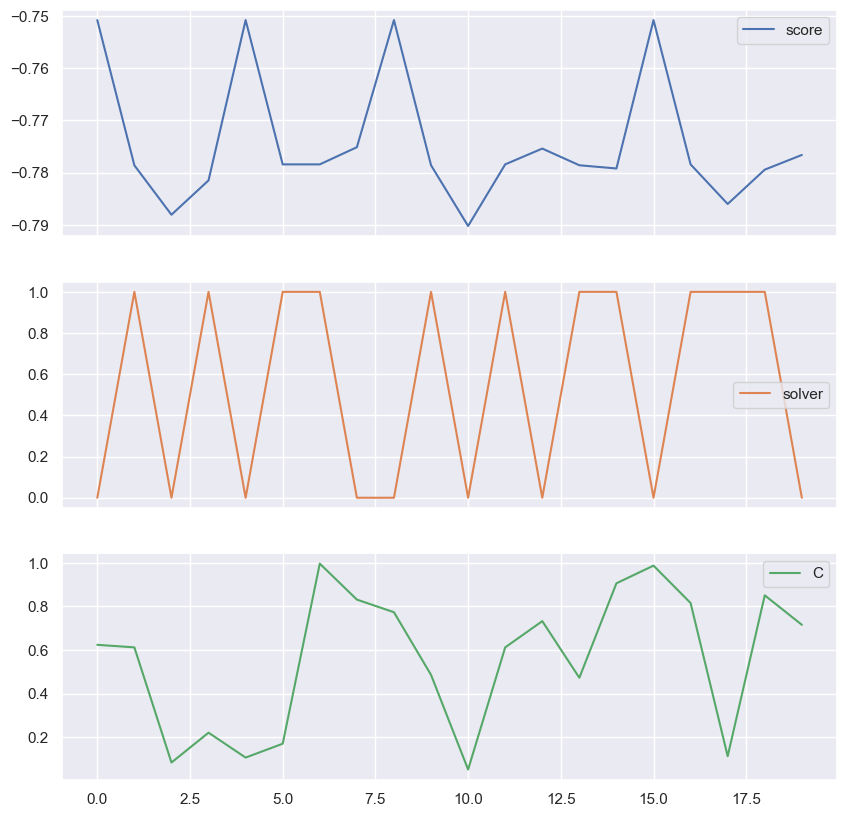

In [175]:

tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['solver'][0],
                      x['misc']['vals']['C'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'solver', 'C'])

tpe_results_df.plot(subplots=True,figsize=(10, 10));

##### 2

In [177]:
space_log_reg={'penalty' : hp.choice(label='penalty', options=['l1', 'l2']),
       'solver' : hp.choice(label='solver', options=['liblinear', 'saga']),
       'C' : hp.uniform(label='C', low=0.01, high=1)
       }

In [194]:
best_2 = fmin(hyperopt_log_reg,
            space=space_log_reg,
            algo=tpe.suggest,
            max_evals=40,
            trials=trials,
            rstate=np.random.default_rng(random_state)
            )

100%|██████████| 40/40 [00:20<00:00,  1.02s/trial, best loss: -0.7908784427162123]


In [196]:
print('Наилучшее значение гиперпараметров {}'.format(best))

Наилучшее значение гиперпараметров {'C': 0.05084775379720359, 'penalty': 0, 'solver': 0}


In [197]:
log_reg_hyp_2 = linear_model.LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=0.5,
    max_iter=1000
    )

log_reg_hyp_2.fit(X_train,y_train)
y_test_predicted_log_reg_hyp_2 = log_reg_hyp.predict(X_test)
y_train_predicted_log_reg_hyp_2 = log_reg_hyp.predict(X_train)

In [198]:
print('accuracy на обучающей выборке: {:.2f}'.format(log_reg_hyp_2.score(X_train,y_train)))
print('accuracy на тестовой выборке: {:.2f}'.format(log_reg_hyp_2.score(X_test,y_test)))
print('f1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_predicted_log_reg_hyp_2)))
print('f1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log_reg_hyp_2)))

accuracy на обучающей выборке: 0.84
accuracy на тестовой выборке: 0.75
f1 на обучающей выборке: 0.88
f1 на тестовой выборке: 0.77


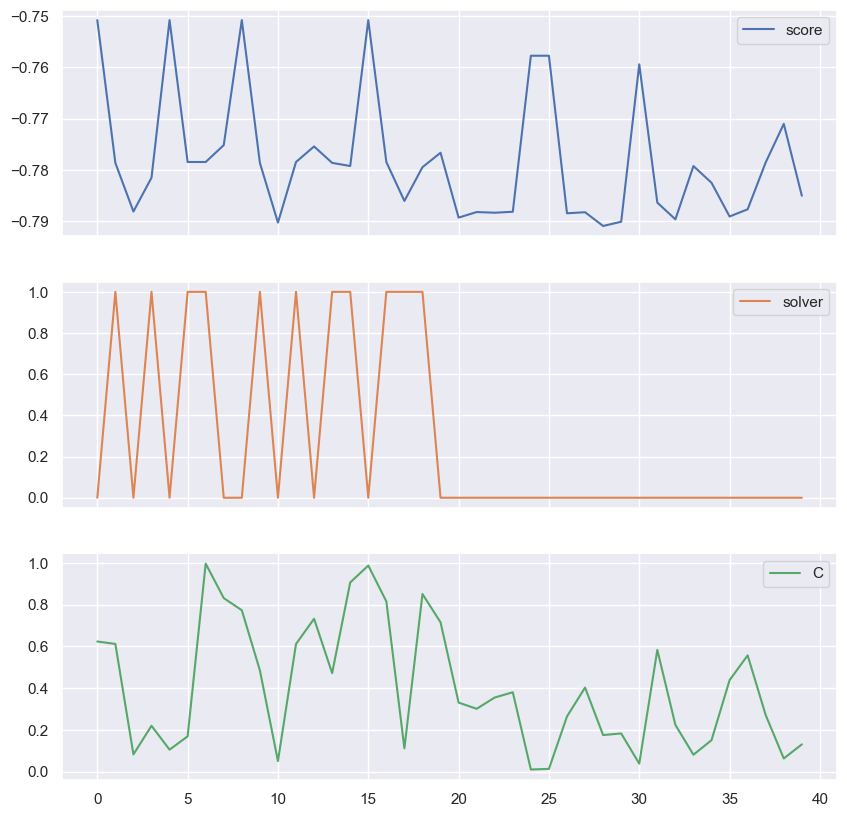

In [199]:

tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['solver'][0],
                      x['misc']['vals']['C'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'solver', 'C'])

tpe_results_df.plot(subplots=True,figsize=(10, 10));

Итоговые значения:

In [200]:
print('Первая группа (penalty= l2, solver=lbfgs,C=0.5,):\n')
print('accuracy на обучающей выборке: {:.2f}'.format(log_reg_hyp.score(X_train,y_train)))
print('accuracy на тестовой выборке: {:.2f}'.format(log_reg_hyp.score(X_test,y_test)))
print('f1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_predicted_log_reg_hyp_2)))
print('f1 на тестовой выборке: {:.2f}\n'.format(metrics.f1_score(y_test, y_test_predicted_log_reg_hyp_2)))

print('Вторая группа(penalty=l1, solver=liblinear,C=0.5,):\n')
print('accuracy на обучающей выборке: {:.2f}'.format(log_reg_hyp_2.score(X_train,y_train)))
print('accuracy на тестовой выборке: {:.2f}'.format(log_reg_hyp_2.score(X_test,y_test)))
print('f1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_predicted_log_reg_hyp_2)))
print('f1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log_reg_hyp_2)))



Первая группа (penalty= l2, solver=lbfgs,C=0.5,):

accuracy на обучающей выборке: 0.87
accuracy на тестовой выборке: 0.75
f1 на обучающей выборке: 0.88
f1 на тестовой выборке: 0.77

Вторая группа(penalty=l1, solver=liblinear,C=0.5,):

accuracy на обучающей выборке: 0.84
accuracy на тестовой выборке: 0.75
f1 на обучающей выборке: 0.88
f1 на тестовой выборке: 0.77


####  оптимизация гиперпараметров случайный лес HYPEROPT

In [192]:
space_rf = {'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [193]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
   
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    
    return -score

In [202]:
trials_rf = hyperopt.Trials()

best_rf = fmin(hyperopt_rf,
            space=space_rf,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials_rf,
            rstate=np.random.default_rng(random_state)
            )

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:31<00:00,  1.58s/trial, best loss: -0.9868380777471687]


In [204]:
print('Наилучшее значение гиперпараметров {}'.format(best_rf))

Наилучшее значение гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}


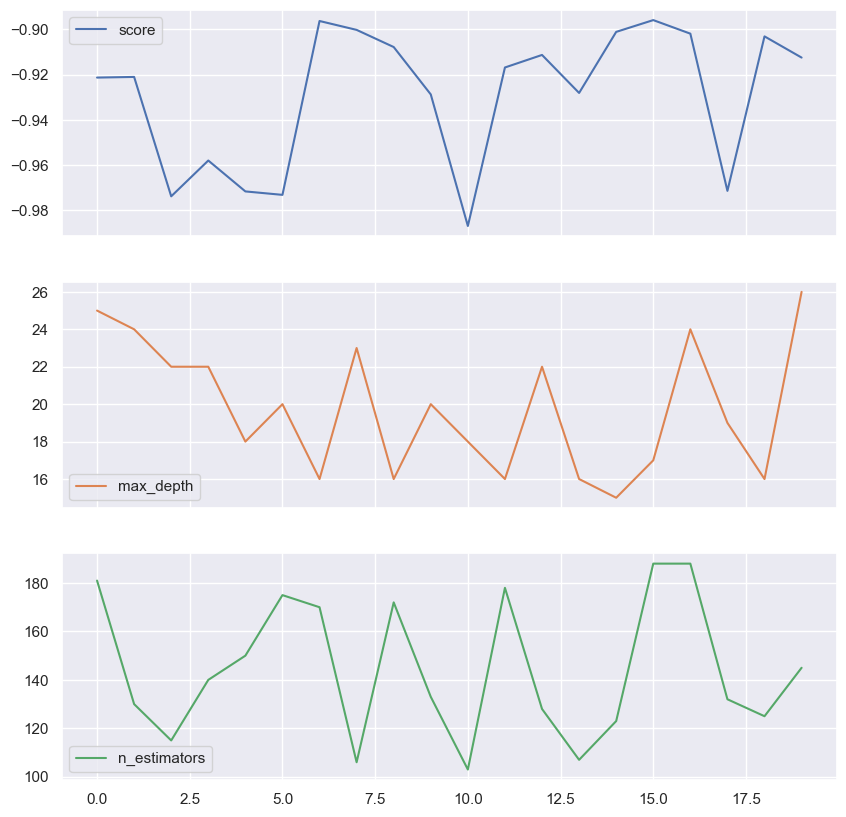

In [213]:

tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials_rf.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])

tpe_results_df.plot(subplots=True,figsize=(10, 10));

In [207]:
rf_hyp = ensemble.RandomForestClassifier(
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf']),
    random_state=random_state
)

rf_hyp.fit(X_train,y_train)

y_test_predicted_rf_hyp = rf_hyp.predict(X_test)
y_train_predicted_rf_hyp = rf_hyp.predict(X_train)

In [208]:
print('accuracy на обучающей выборке: {:.2f}'.format(rf_hyp.score(X_train,y_train)))
print('accuracy на тестовой выборке: {:.2f}'.format(rf_hyp.score(X_test,y_test)))
print('f1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_predicted_rf_hyp)))
print('f1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_rf_hyp)))

accuracy на обучающей выборке: 0.99
accuracy на тестовой выборке: 0.79
f1 на обучающей выборке: 0.99
f1 на тестовой выборке: 0.81


### OPTUNA

####  оптимизация гиперпараметров логистической регрессии OPTUNA

##### 1

In [218]:
def optuna_log_reg(trial):
 
  penalty = trial.suggest_categorical('penalty', ['l2','none'])
  solver = trial.suggest_categorical('solver', ['lbfgs','saga'])
  c = trial.suggest_float('C', 0.01, 1)

 
  model = linear_model.LogisticRegression(random_state=42, max_iter=1000, penalty=penalty, solver=solver, C=c)
  
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [219]:
study_log_reg = optuna.create_study(study_name="LogisticRegression", direction="maximize")

study_log_reg.optimize(optuna_log_reg, n_trials=20)

[I 2023-07-07 19:49:32,383] A new study created in memory with name: LogisticRegression


c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-07-07 19:50:07,976] Trial 0 finished with value: 0.9212381244253754 and parameters: {'penalty': 'none', 'solver': 'saga', 'C': 0.8261175815707599}. Best is trial 0 with value: 0.9212381244253754.
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_mo

In [220]:
print("Наилучшие значения гиперпараметров {}".format(study_log_reg.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_log_reg.best_value))

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.5605841010275008}
f1_score на обучающем наборе: 0.99


In [223]:
log_reg_op_1 = linear_model.LogisticRegression(**study_log_reg.best_params,random_state=random_state, max_iter=1000)
log_reg_op_1.fit(X_train, y_train)
y_train_predicted_log_reg_op_1 = log_reg_op_1.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg_op_1.score(X_test, y_test)))
y_test_predicted_log_reg_op_1 = log_reg_op_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log_reg_op_1)))

c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


accuracy на тестовом наборе: 0.70
f1_score на тестовом наборе: 0.73


c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### 2

In [224]:
def optuna_log_reg_2(trial):
 
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  c = trial.suggest_float('C', 0.01, 1)

  
  model = linear_model.LogisticRegression(random_state=42, max_iter=1000, penalty=penalty, solver=solver, C=c)
  
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [225]:
study_log_reg_2 = optuna.create_study(study_name="LogisticRegression", direction="maximize")

study_log_reg_2.optimize(optuna_log_reg, n_trials=20)

[I 2023-07-07 19:58:07,416] A new study created in memory with name: LogisticRegression
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver optio

In [226]:
print("Наилучшие значения гиперпараметров {}".format(study_log_reg_2.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_log_reg_2.best_value))

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.4293289937611581}
f1_score на обучающем наборе: 0.99


In [227]:
log_reg_op_2 = linear_model.LogisticRegression(**study_log_reg.best_params,random_state=random_state, max_iter=1000)
log_reg_op_2.fit(X_train, y_train)
y_train_predicted_log_reg_op_2 = log_reg_op_2.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg_op_1.score(X_test, y_test)))
y_test_predicted_log_reg_op_2 = log_reg_op_2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log_reg_op_2)))

c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


accuracy на тестовом наборе: 0.70
f1_score на тестовом наборе: 0.73


c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


####  оптимизация гиперпараметров логистической регрессии OPTUNA

In [228]:
def optuna_rf(trial):

  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
 
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  

In [229]:
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study_rf.optimize(optuna_rf, n_trials=20)

[I 2023-07-07 20:03:29,525] A new study created in memory with name: RandomForestClassifier
[I 2023-07-07 20:03:31,238] Trial 0 finished with value: 0.9734351145038167 and parameters: {'n_estimators': 137, 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9734351145038167.
[I 2023-07-07 20:03:33,301] Trial 1 finished with value: 0.9576864535768645 and parameters: {'n_estimators': 175, 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9734351145038167.
[I 2023-07-07 20:03:35,280] Trial 2 finished with value: 0.9566544566544566 and parameters: {'n_estimators': 168, 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9734351145038167.
[I 2023-07-07 20:03:36,535] Trial 3 finished with value: 0.8969072164948454 and parameters: {'n_estimators': 132, 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9734351145038167.
[I 2023-07-07 20:03:37,832] Trial 4 finished with value: 0.9204131227217497 and parameters: {'n

In [230]:
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 175, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [231]:
rf_op = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=random_state, )
rf_op.fit(X_train, y_train)
y_train_pred_rf_op = rf_op.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(rf_op.score(X_test, y_test)))
y_test_pred_rf_op = rf_op.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf_op)))

accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


## Выводы

In [232]:
print('Результаты оптимизации гиперпараметнов логистической регрессии:\n')
print('f1_score на тестовом наборе default модели: {:.2f}'.format(metrics.f1_score(y_test, lr_y_test_predicted)))
print('f1 на тестовой выборке GridSearchCV: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log)))
print('f1 на тестовой выборке RandomizedSearchCV: {:.2f}'.format(metrics.f1_score(y_test,lr_rs_y_test_predicted)))
print('f1 на тестовой выборке HYPEROPT_1: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log_reg_hyp)))
print('f1 на тестовой выборке HYPEROPT_2: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log_reg_hyp_2)))
print('f1_score на тестовом наборе OPTUNA_1: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log_reg_op_1)))
print('f1_score на тестовом наборе OPTUNA_2: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_log_reg_op_2)))

Результаты оптимизации гиперпараметнов логистической регрессии:

f1_score на тестовом наборе default модели: 0.78
f1 на тестовой выборке GridSearchCV: 0.78
f1 на тестовой выборке RandomizedSearchCV: 0.78
f1 на тестовой выборке HYPEROPT_1: 0.77
f1 на тестовой выборке HYPEROPT_2: 0.77
f1_score на тестовом наборе OPTUNA_1: 0.73
f1_score на тестовом наборе OPTUNA_2: 0.73


In [233]:
print('Результаты оптимизации гиперпараметнов случайный лес:\n')
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, rf_y_text_predicted)))
print('f1 на тестовой выборке GridSearchCV: {:.2f}'.format(metrics.f1_score(y_test,y_test_predicted_grid_search_rf)))
print('f1 на тестовой выборке RandomizedSearchCV: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_rand_rf)))
print('f1 на тестовой выборке HYPEROPT: {:.2f}'.format(metrics.f1_score(y_test, y_test_predicted_rf_hyp)))
print('f1_score на тестовом наборе OPTUNA: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf_op)))

Результаты оптимизации гиперпараметнов случайный лес:

f1_score на тестовом наборе: 0.80
f1 на тестовой выборке GridSearchCV: 0.80
f1 на тестовой выборке RandomizedSearchCV: 0.80
f1 на тестовой выборке HYPEROPT: 0.81
f1_score на тестовом наборе OPTUNA: 0.80
